In [1]:
# /kaggle/input/clc-xray/test/_annotations.coco.json

In [2]:
import os
import json
import glob

dataset_path = "/kaggle/input/clc-xray"

json_files = glob.glob(os.path.join(dataset_path, "*", "_annotations.coco.json"))
print("Annotation Files Found:", json_files)

annotation_path = os.path.join(dataset_path, "train", "_annotations.coco.json")

with open(annotation_path, "r") as f:
    json_data = json.load(f)

print("Keys in JSON:", json_data.keys())


Annotation Files Found: ['/kaggle/input/clc-xray/valid/_annotations.coco.json', '/kaggle/input/clc-xray/test/_annotations.coco.json', '/kaggle/input/clc-xray/train/_annotations.coco.json']
Keys in JSON: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


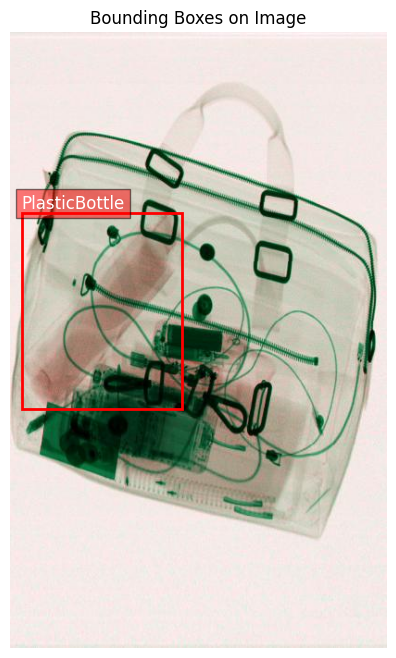

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

category_map = {cat["id"]: cat["name"] for cat in json_data["categories"]}

def plot_bboxes(image_dir, image_info, annotations):
    """Plots bounding boxes on an image using COCO annotations."""
    image_path = os.path.join(image_dir, image_info["file_name"])

    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read image. Check file format.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for ann in annotations:
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, category_map.get(ann["category_id"], "Unknown"), 
                color="white", fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.title("Bounding Boxes on Image")
    plt.show()

image_sample = json_data["images"][0]
image_dir = os.path.join(dataset_path, "train")  # Adjust for test/valid if needed
image_annotations = [ann for ann in json_data["annotations"] if ann["image_id"] == image_sample["id"]]

plot_bboxes(image_dir, image_sample, image_annotations)


In [4]:
import glob

train_images = glob.glob(os.path.join(dataset_path, "train", "*.*"))
test_images = glob.glob(os.path.join(dataset_path, "test", "*.*"))
valid_images = glob.glob(os.path.join(dataset_path, "valid", "*.*"))

print(f"Train Images: {len(train_images)} | Sample: {train_images[:5]}")
print(f"Test Images: {len(test_images)} | Sample: {test_images[:5]}")
print(f"Valid Images: {len(valid_images)} | Sample: {valid_images[:5]}")


Train Images: 3187 | Sample: ['/kaggle/input/clc-xray/train/14_40_57_902_png.rf.b22655f7f996cb15ebe22352da3ca316.jpg', '/kaggle/input/clc-xray/train/20_23_15_859_png.rf.fff05ae10df04be916c8686da7d07500.jpg', '/kaggle/input/clc-xray/train/14_41_06_754_png.rf.02656f934727d060b3c365360989d998.jpg', '/kaggle/input/clc-xray/train/15_27_02_225_png.rf.1d83d3ab8d6781927e65fd3813e36376.jpg', '/kaggle/input/clc-xray/train/11_26_16_589_png.rf.cbe70bafa3cfb2d566e63ff52a55b520.jpg']
Test Images: 957 | Sample: ['/kaggle/input/clc-xray/test/20_37_29_671_png.rf.1286d40d36684ffc548c8ec1040d32cb.jpg', '/kaggle/input/clc-xray/test/13_38_09_250_png.rf.b25716a99761f06fd425c06a18b0c6be.jpg', '/kaggle/input/clc-xray/test/06_52_33_484_png.rf.422794b05ac18ede6344152fd169ce51.jpg', '/kaggle/input/clc-xray/test/06_30_14_000_png.rf.c2d8f6768498d027eb5ed391a84365e9.jpg', '/kaggle/input/clc-xray/test/09_58_01_779_png.rf.cfc77bccc128b790c004e3acfd28c179.jpg']
Valid Images: 957 | Sample: ['/kaggle/input/clc-xray/vali

In [5]:
output_path = "/kaggle/working/clc-xray-yolo"
os.makedirs(output_path, exist_ok=True)

json_files = glob.glob(os.path.join(dataset_path, "*", "_annotations.coco.json"))

def convert_coco_to_yolo(json_path, split):
    """Convert COCO JSON to YOLO format and save annotations."""
    with open(json_path, "r") as f:
        data = json.load(f)

    category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
    
    # Make YOLO annotation folder
    label_dir = os.path.join(output_path, split, "labels")
    os.makedirs(label_dir, exist_ok=True)
    
    # Process each annotation
    for ann in data["annotations"]:
        image_info = next(img for img in data["images"] if img["id"] == ann["image_id"])
        img_w, img_h = image_info["width"], image_info["height"]
        
        # YOLO format: Normalize bbox values
        x, y, w, h = ann["bbox"]
        x_center, y_center = x + w / 2, y + h / 2
        x_center /= img_w
        y_center /= img_h
        w /= img_w
        h /= img_h
        
        # Save annotation
        label_path = os.path.join(label_dir, os.path.splitext(image_info["file_name"])[0] + ".txt")
        with open(label_path, "a") as f:
            f.write(f"{ann['category_id']} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ YOLO annotations saved for {split} in {label_dir}")

# Convert all dataset splits
for json_file in json_files:
    split = os.path.basename(os.path.dirname(json_file))  # Extract train/test/valid
    convert_coco_to_yolo(json_file, split)


✅ YOLO annotations saved for valid in /kaggle/working/clc-xray-yolo/valid/labels
✅ YOLO annotations saved for test in /kaggle/working/clc-xray-yolo/test/labels
✅ YOLO annotations saved for train in /kaggle/working/clc-xray-yolo/train/labels


📊 Class Distribution: {'blade': 1597, 'VacuumCup': 1213, 'GlassBottle': 351, 'Cans': 409, 'scissors': 1201, 'Tin': 466, 'PlasticBottle': 3196, 'SprayCans': 571, 'CartonDrinks': 954, 'SwissArmyKnife': 496, 'dagger': 494, 'knife': 347}


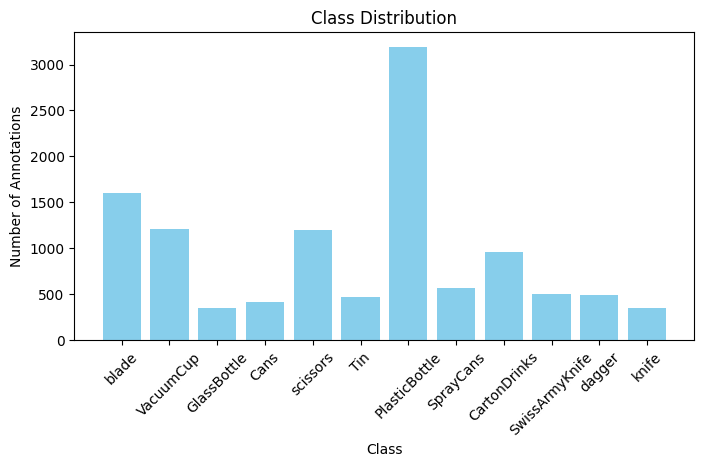

In [6]:
from collections import Counter

label_counts = Counter()

for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)
    
    for ann in data["annotations"]:
        label_counts[ann["category_id"]] += 1

category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
label_counts_named = {category_map[k]: v for k, v in label_counts.items()}

print("📊 Class Distribution:", label_counts_named)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(label_counts_named.keys(), label_counts_named.values(), color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.title("Class Distribution")
plt.show()


In [7]:
import shutil

for split in ["train", "valid", "test"]:
    src_img_dir = os.path.join(dataset_path, split)
    dest_img_dir = os.path.join(output_path, split, "images")
    os.makedirs(dest_img_dir, exist_ok=True)

    # Move images
    for img_file in glob.glob(os.path.join(src_img_dir, "*.*")):
        shutil.copy(img_file, dest_img_dir)

print("✅ Dataset Organized in YOLO format!")


✅ Dataset Organized in YOLO format!


In [8]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 14.9 MB/s eta 0:00:00a 0:00:01


In [9]:
!pip install torch torchvision opencv-python numpy matplotlib pyyaml tqdm

In [10]:
import json
import glob

# Locate one annotation file (train set is usually the best choice)
annotation_file = glob.glob("/kaggle/input/clc-xray/train/_annotations.coco.json")[0]

# Load COCO JSON
with open(annotation_file, "r") as f:
    json_data = json.load(f)

# Extract category ID → Name mapping from the dataset
dataset_classes = {cat["id"]: cat["name"] for cat in json_data["categories"]}

# Print the actual class order from dataset
sorted_classes = [dataset_classes[i] for i in sorted(dataset_classes.keys())]
print("✅ Classes in correct order:", sorted_classes)

✅ Classes in correct order: ['gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 'PlasticBottle', 'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 'blade', 'dagger', 'knife', 'scissors']


In [11]:
import yaml
import os

# Define dataset paths
dataset_path = "/kaggle/working/clc-xray-yolo"  # Update path if needed
yaml_path = os.path.join(dataset_path, "data.yaml")

# Correct class order
class_names = [
    'gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 'PlasticBottle', 
    'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 'blade', 'dagger', 'knife', 'scissors'
]

# Prepare YAML structure
data_yaml = {
    "train": os.path.join(dataset_path, "train/images"),
    "val": os.path.join(dataset_path, "valid/images"),
    "test": os.path.join(dataset_path, "test/images"),
    "nc": len(class_names),  # Number of classes
    "names": class_names,  # Corrected order
}

# Save to YAML file with correct format
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print(f"✅ Updated `data.yaml` with correct class order at: {yaml_path}")

✅ Updated `data.yaml` with correct class order at: /kaggle/working/clc-xray-yolo/data.yaml


In [12]:
cat /kaggle/working/clc-xray-yolo/data.yaml

train: /kaggle/working/clc-xray-yolo/train/images
val: /kaggle/working/clc-xray-yolo/valid/images
test: /kaggle/working/clc-xray-yolo/test/images
nc: 13
names:
- gun-knife-wrench-pilers-scissors
- Cans
- CartonDrinks
- GlassBottle
- PlasticBottle
- SprayCans
- SwissArmyKnife
- Tin
- VacuumCup
- blade
- dagger
- knife
- scissors


In [13]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 117 not upgraded.


In [14]:
!git lfs install
!git clone https://huggingface.co/spaces/BoukamchaSmartVisions/Yolov10

Git LFS initialized.
Cloning into 'Yolov10'...
remote: Enumerating objects: 119, done.
remote: Total 119 (delta 0), reused 0 (delta 0), pack-reused 119 (from 1)
Receiving objects: 100% (119/119), 1.08 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Filtering content: 100% (7/7), 408.17 MiB | 113.45 MiB/s, done.


In [15]:
weights_path = "/kaggle/working/yolo_weights"
os.makedirs(weights_path, exist_ok=True)
print(f"✅ YOLO Weights folder created at: {weights_path}")

✅ YOLO Weights folder created at: /kaggle/working/yolo_weights


In [16]:
!mkdir -p /kaggle/working/yolo_weights
!mv Yolov10/yolov10n.pt /kaggle/working/yolo_weights/

In [17]:
!mv /kaggle/input/yolov11n/other/default/1/yolov11n.pt /kaggle/working/yolo_weights/

mv: cannot remove '/kaggle/input/yolov11n/other/default/1/yolov11n.pt': Read-only file system


In [18]:
cp /kaggle/input/yolov11n/other/default/1/yolov11n.pt /kaggle/working/yolo_weights/

In [20]:
from ultralytics import YOLO

yolo_weights_path = "/kaggle/working/yolo_weights/yolov11n.pt"  

if os.path.exists(yolo_weights_path):
    print("YOLOv11 weights found!")
    model = YOLO(yolo_weights_path)  
    model.info()
else:
    print("YOLOv11 weights not found! Check the path.")

YOLOv11 weights found!
YOLO11n summary: 319 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


In [22]:
from ultralytics import YOLO

try:
    # Load the model
    model = YOLO(yolo_weights_path)
    print("YOLOv11 model loaded successfully!")
except Exception as e:
    print("YOLOv11 model could not be loaded.")
    print(e)

YOLOv11 model loaded successfully!


In [23]:
dataset_path = "/kaggle/working/clc-xray-yolo"
yaml_path = os.path.join(dataset_path, "data.yaml")

# Verify dataset structure
print("Checking dataset structure...\n")
!ls "$dataset_path"

Checking dataset structure...

data.yaml  test  train	valid


In [24]:
dataset_path = "/kaggle/working/clc-xray-yolo"
yaml_path = os.path.join(dataset_path, "data.yaml")

yaml_content = f"""train: {dataset_path}/train/images
val: {dataset_path}/valid/images
test: {dataset_path}/test/images

nc: 13
names: ['gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 
        'PlasticBottle', 'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 
        'blade', 'dagger', 'knife', 'scissors']
"""

# Overwrite data.yaml with the correct paths
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"✅ Updated `data.yaml` at: {yaml_path}")

✅ Updated `data.yaml` at: /kaggle/working/clc-xray-yolo/data.yaml


In [25]:
!cat "/kaggle/working/clc-xray-yolo/data.yaml"

train: /kaggle/working/clc-xray-yolo/train/images
val: /kaggle/working/clc-xray-yolo/valid/images
test: /kaggle/working/clc-xray-yolo/test/images

nc: 13
names: ['gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 
        'PlasticBottle', 'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 
        'blade', 'dagger', 'knife', 'scissors']


In [26]:
model.info()

YOLO11n summary: 319 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


(319, 2590035, 0, 6.4406016)

In [27]:
from ultralytics import YOLO

# Define dataset YAML path
yaml_path = "/kaggle/working/clc-xray-yolo/data.yaml"  # Updated path

# Load YOLOv11 model
model = YOLO("/kaggle/working/yolo_weights/yolov11n.pt")  # Updated weights path

# Start Training
model.train(
    data=yaml_path,
    epochs=50,
    batch=16,
    imgsz=640,
    optimizer="AdamW",
    device=0,
    workers=2,
    project="/kaggle/working/Yolov11_results",  # Updated results path
    name="clc_xray_yolov11",
    cache=True,
    augment=True,
    save=True,
    save_period=5  # Save weights every 5 epochs
)

print("✅ YOLOv11 training started successfully!")


Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolo_weights/yolov11n.pt, data=/kaggle/working/clc-xray-yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=True, device=0, workers=2, project=/kaggle/working/Yolov11_results, name=clc_xray_yolov11, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

100%|██████████| 755k/755k [00:00<00:00, 18.7MB/s]


Overriding model.yaml nc=1 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/clc-xray-yolo/train/labels... 3186 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3186/3186 [00:02<00:00, 1190.62it/s]


train: New cache created: /kaggle/working/clc-xray-yolo/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.9GB RAM): 100%|██████████| 3186/3186 [00:04<00:00, 687.61it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/clc-xray-yolo/valid/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:00<00:00, 1069.24it/s]

val: New cache created: /kaggle/working/clc-xray-yolo/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.9GB RAM): 100%|██████████| 956/956 [00:01<00:00, 731.44it/s]


Plotting labels to /kaggle/working/Yolov11_results/clc_xray_yolov11/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/Yolov11_results/clc_xray_yolov11
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.49G      1.663      2.977      1.635          2        640: 100%|██████████| 200/200 [00:35<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


                   all        956       2317      0.484      0.164     0.0937     0.0577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.43G      1.455       2.15      1.522          4        640: 100%|██████████| 200/200 [00:33<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


                   all        956       2317      0.342       0.32      0.209      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.44G      1.364      1.863      1.469          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


                   all        956       2317      0.231      0.426      0.309      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.42G      1.274      1.675      1.413          4        640: 100%|██████████| 200/200 [00:35<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


                   all        956       2317      0.383      0.419      0.362      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.43G       1.19      1.501       1.34          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


                   all        956       2317      0.584      0.463      0.389      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.43G      1.143      1.394      1.308          8        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


                   all        956       2317      0.506      0.522      0.491      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.42G      1.111      1.339       1.28          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.57it/s]


                   all        956       2317      0.423      0.504      0.477      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.44G      1.046      1.226      1.234          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.71it/s]

                   all        956       2317      0.491      0.563      0.502      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.42G     0.9984      1.187      1.199         11        640: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.66it/s]


                   all        956       2317      0.413      0.601      0.557      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.45G     0.9668      1.112      1.188          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.60it/s]

                   all        956       2317      0.522      0.596      0.589      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.44G     0.9526      1.077      1.177          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.80it/s]

                   all        956       2317      0.514      0.602      0.581      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.42G     0.9142       1.02      1.154          7        640: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.78it/s]


                   all        956       2317       0.56      0.599      0.628      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.44G     0.9055     0.9996       1.15          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


                   all        956       2317      0.578      0.579       0.61      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.43G     0.8756     0.9491      1.136          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


                   all        956       2317      0.629       0.63      0.645      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.5G      0.855     0.9453      1.119          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.81it/s]

                   all        956       2317      0.652        0.6      0.656      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.43G     0.8664     0.9321      1.122          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


                   all        956       2317      0.604      0.587      0.606      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.42G     0.8344     0.8886       1.11          8        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.75it/s]

                   all        956       2317      0.661      0.655      0.672      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.43G     0.8094     0.8565       1.09          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]

                   all        956       2317      0.647      0.664      0.688      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.49G     0.7984     0.8466      1.086          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.71it/s]


                   all        956       2317      0.699      0.671      0.714      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.43G     0.8059     0.8231      1.089          7        640: 100%|██████████| 200/200 [00:34<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.70it/s]

                   all        956       2317      0.679      0.684      0.714      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.42G     0.7759     0.7943      1.073          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.72it/s]


                   all        956       2317      0.713      0.657       0.72      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.43G     0.7585     0.7735      1.066          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.77it/s]

                   all        956       2317      0.721      0.686      0.732      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.46G     0.7513     0.7665      1.057          3        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.76it/s]

                   all        956       2317      0.664      0.704      0.716      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.43G     0.7433     0.7667      1.063          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.77it/s]

                   all        956       2317      0.679      0.691      0.724      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.51G     0.7263     0.7327      1.044          3        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.64it/s]

                   all        956       2317      0.751      0.669      0.732       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.42G     0.7199     0.7194      1.041          3        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.75it/s]

                   all        956       2317      0.746      0.721      0.759      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.43G     0.7109     0.7137      1.041          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.86it/s]

                   all        956       2317      0.781      0.699      0.763      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.43G     0.6944     0.6872      1.026          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.74it/s]

                   all        956       2317      0.767      0.713      0.755       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.43G     0.6883     0.7015       1.03          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.67it/s]

                   all        956       2317      0.759      0.725      0.763      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.49G      0.694     0.6874      1.035          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.78it/s]

                   all        956       2317      0.783      0.734      0.776      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.49G     0.6709     0.6601      1.021          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.73it/s]

                   all        956       2317      0.753      0.727      0.774      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.42G     0.6605     0.6412      1.012          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.83it/s]

                   all        956       2317      0.786      0.724       0.78      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.45G     0.6524     0.6329      1.012          8        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.66it/s]

                   all        956       2317      0.787      0.751       0.79      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.43G     0.6515     0.6246       1.01          8        640: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.84it/s]

                   all        956       2317      0.795      0.737      0.793      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.43G      0.635     0.6115      1.003          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.83it/s]

                   all        956       2317      0.809      0.754        0.8      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.42G     0.6287     0.6137      1.002          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.84it/s]

                   all        956       2317      0.788      0.742      0.797      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.43G     0.6218     0.6047     0.9995          5        640: 100%|██████████| 200/200 [00:34<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.65it/s]

                   all        956       2317      0.787      0.743      0.797      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.49G     0.6216     0.5959     0.9969          3        640: 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.87it/s]

                   all        956       2317       0.81      0.739        0.8      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.43G      0.613     0.5887     0.9946          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.84it/s]

                   all        956       2317      0.801      0.766      0.804      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.45G     0.5912     0.5542     0.9831          8        640: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.90it/s]

                   all        956       2317      0.824      0.764      0.804      0.639


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.41G     0.8382     0.7857      1.119          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.60it/s]

                   all        956       2317      0.827      0.773      0.817      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.42G     0.8121     0.7387      1.091          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.82it/s]

                   all        956       2317      0.916      0.746      0.818       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.42G      0.799     0.7187      1.085          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.76it/s]

                   all        956       2317      0.846       0.77       0.83      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.41G     0.7865     0.6945      1.081          6        640: 100%|██████████| 200/200 [00:34<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.82it/s]

                   all        956       2317      0.854      0.773       0.83      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.42G     0.7698     0.6742      1.063          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.66it/s]

                   all        956       2317      0.844       0.79      0.835      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.42G     0.7648     0.6582      1.056          2        640: 100%|██████████| 200/200 [00:34<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]

                   all        956       2317      0.849      0.767      0.838      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.42G     0.7592     0.6527      1.063          4        640: 100%|██████████| 200/200 [00:34<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.78it/s]

                   all        956       2317      0.844      0.789      0.839      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.42G     0.7394     0.6254      1.043          6        640: 100%|██████████| 200/200 [00:33<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.71it/s]

                   all        956       2317      0.849      0.781      0.841      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.41G     0.7412      0.614      1.044          3        640: 100%|██████████| 200/200 [00:33<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.58it/s]

                   all        956       2317      0.844      0.794      0.843      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.43G     0.7316     0.6043       1.04          4        640: 100%|██████████| 200/200 [00:33<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.80it/s]

                   all        956       2317      0.852      0.788      0.843      0.695



50 epochs completed in 0.564 hours.
Optimizer stripped from /kaggle/working/Yolov11_results/clc_xray_yolov11/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/Yolov11_results/clc_xray_yolov11/weights/best.pt, 5.5MB

Validating /kaggle/working/Yolov11_results/clc_xray_yolov11/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:10<00:00,  2.84it/s]


                   all        956       2317      0.833      0.798       0.84       0.69
                  Cans         83         87      0.872       0.78      0.833      0.712
          CartonDrinks        208        228      0.966      0.943      0.983      0.812
           GlassBottle         32         45      0.113     0.0222     0.0785     0.0525
         PlasticBottle        462        607      0.897      0.829        0.9      0.754
             SprayCans         87         96      0.859      0.594      0.675      0.547
        SwissArmyKnife        113        114      0.922      0.947      0.948      0.705
                   Tin         82         93      0.812      0.763      0.842      0.714
             VacuumCup        182        192      0.902      0.917       0.96      0.829
                 blade        263        398      0.934      0.897      0.952      0.695
                dagger        121        122      0.857      0.967      0.969      0.825
                 knif

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/Yolov11_results/clc_xray_yolov11
✅ YOLOv11 training started successfully!


In [29]:
import os

weights_dir = "/kaggle/working/Yolov11_results/clc_xray_yolov11/weights"

if os.path.exists(weights_dir):
    print("✅ Checking available weights:\n")
    print(os.listdir(weights_dir))
else:
    print("⚠️ Weights directory does not exist!")

✅ Checking available weights:

['epoch10.pt', 'epoch5.pt', 'epoch0.pt', 'epoch30.pt', 'epoch15.pt', 'epoch35.pt', 'epoch25.pt', 'best.pt', 'epoch40.pt', 'epoch45.pt', 'last.pt', 'epoch20.pt']


In [31]:
yolov11_best_path = "/kaggle/working/Yolov11_results/clc_xray_yolov11/weights/best.pt"
model = YOLO(yolov11_best_path)

# Define the test set path (from the original dataset)
test_yaml_path = "/kaggle/working/clc-xray-yolo/data.yaml"  # Updated path


In [32]:
metrics = model.val(data=test_yaml_path, split="test", device=0)

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/clc-xray-yolo/test/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:00<00:00, 1222.54it/s]

val: New cache created: /kaggle/working/clc-xray-yolo/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.89it/s]


                   all        956       1421      0.772      0.594       0.65      0.534
                  Cans         37         47      0.763      0.191      0.316      0.271
          CartonDrinks         46         51      0.841      0.621      0.753       0.58
           GlassBottle         83        109          0          0     0.0971      0.056
         PlasticBottle        488        590      0.796      0.676      0.753      0.596
             SprayCans         90        114       0.73     0.0789       0.14        0.1
        SwissArmyKnife         17         17      0.913      0.882      0.889      0.695
                   Tin         45         49      0.803      0.612      0.672      0.543
             VacuumCup        314        321      0.884      0.826      0.902      0.799
                 blade         27         34      0.775      0.647      0.652      0.494
                dagger         19         19       0.92      0.895      0.895       0.81
                 knif

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val


In [33]:
import shutil

# Define results path
results_path = "/kaggle/working/Yolov11_results/test_predictions/"  # Updated path

# Ensure the destination directory exists
os.makedirs(results_path, exist_ok=True)

# Move test predictions to the new directory
shutil.move("runs/detect/val", results_path)

print(f"✅ Test set predictions saved at: {results_path}")


✅ Test set predictions saved at: /kaggle/working/Yolov11_results/test_predictions/


In [34]:
# Load the best-trained YOLOv11 model
model = YOLO(yolov11_best_path)

# Define the test set image path
test_images_path = "/kaggle/working/clc-xray-yolo/test/images"  # Updated path

# Run inference on test images
results = model.predict(source=test_images_path, save=True, conf=0.25)

# Check where YOLO saved predictions
print("✅ YOLO Test Predictions saved in: runs/detect/predict/")



image 1/956 /kaggle/working/clc-xray-yolo/test/images/05_20_27_625_png.rf.1b267931baa1f6e5d48667f95695d374.jpg: 640x608 1 VacuumCup, 46.0ms
image 2/956 /kaggle/working/clc-xray-yolo/test/images/05_24_05_796_png.rf.6194ae409d5a6b35cae0cea21bab968e.jpg: 640x480 1 PlasticBottle, 43.3ms
image 3/956 /kaggle/working/clc-xray-yolo/test/images/05_24_40_875_png.rf.9df32b927a67834ac6efc6631c0798d2.jpg: 640x640 1 CartonDrinks, 8.4ms
image 4/956 /kaggle/working/clc-xray-yolo/test/images/05_25_25_703_png.rf.b3ffc7590a2072577e2c6a62a66c73dd.jpg: 640x640 1 Cans, 1 PlasticBottle, 2 VacuumCups, 7.8ms
image 5/956 /kaggle/working/clc-xray-yolo/test/images/05_27_15_406_png.rf.af1ec5b23304c5086affa15bbacd953a.jpg: 640x640 1 VacuumCup, 7.8ms
image 6/956 /kaggle/working/clc-xray-yolo/test/images/05_29_34_453_png.rf.b4ab31f1dd47ba90e59109ed8fbb45b0.jpg: 352x640 1 VacuumCup, 42.3ms
image 7/956 /kaggle/working/clc-xray-yolo/test/images/05_34_07_015_png.rf.a3df24d6667e9dd0e02ffbf7bcdea42a.jpg: 416x640 4 Plastic

In [35]:
import shutil
import os

# Path where YOLO saved predictions
yolo_predictions_path = "runs/detect/predict"
save_path = "/kaggle/working/Yolov11_results/test_predictions/"  # Updated path

# Ensure the destination directory exists
os.makedirs(save_path, exist_ok=True)

# Move predictions to the new directory
shutil.move(yolo_predictions_path, save_path)

print(f"✅ Test predictions saved to: {save_path}")


✅ Test predictions saved to: /kaggle/working/Yolov11_results/test_predictions/


In [36]:
# Extract metrics
precision = metrics.box.p.mean()  # Mean precision across all classes
recall = metrics.box.r.mean()     # Mean recall across all classes
f1_score = metrics.box.f1.mean()  # Mean F1-score
map50 = metrics.box.map50         # Mean Average Precision (mAP) @ 50
map50_95 = metrics.box.map        # Mean Average Precision (mAP) @ 50-95

# Print results
print("**YOLOv11 Test Set Evaluation Results**")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"mAP@50: {map50:.4f}")
print(f"mAP@50-95: {map50_95:.4f}")
     

**YOLOv11 Test Set Evaluation Results**
Precision: 0.7723
Recall: 0.5945
F1-Score: 0.6422
mAP@50: 0.6499
mAP@50-95: 0.5343


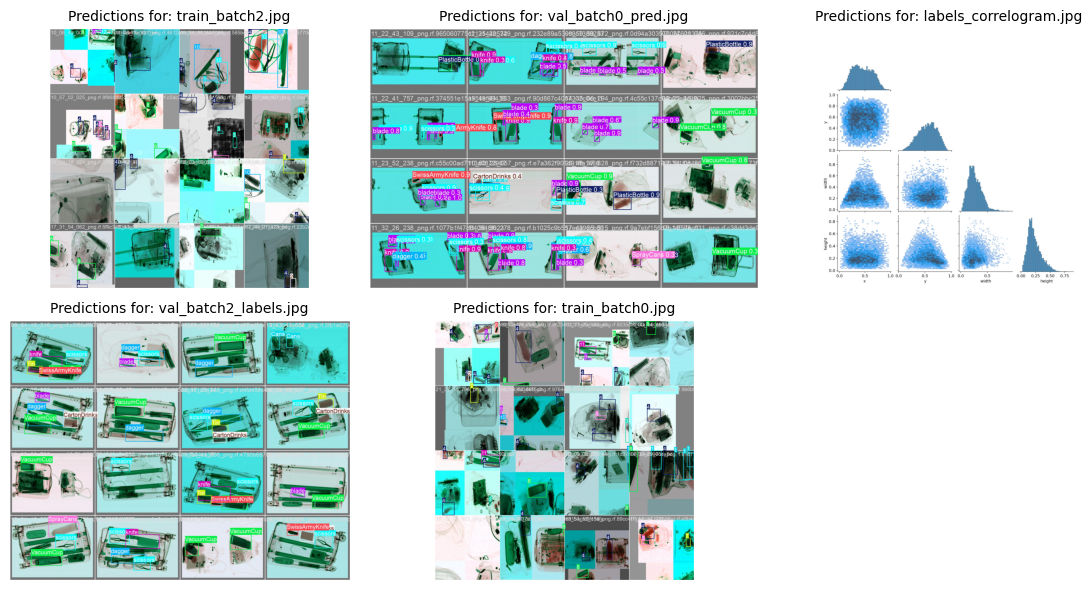

In [38]:
import os
import cv2
import matplotlib.pyplot as plt

# Define test results path
test_results_path = "/kaggle/working/Yolov11_results/clc_xray_yolov11"  # Updated path

# Get a list of image files only
valid_extensions = (".jpg", ".jpeg", ".png")
sample_files = [f for f in os.listdir(test_results_path) if f.endswith(valid_extensions)][:5]

# Plot predictions with filenames
plt.figure(figsize=(12, 6))
for idx, img_file in enumerate(sample_files):
    img_path = os.path.join(test_results_path, img_file)
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Skipping file (not an image): {img_file}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, idx+1)
    plt.imshow(img)
    plt.title(f"Predictions for: {img_file}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


⚠️ No valid image predictions found!
CSV Columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


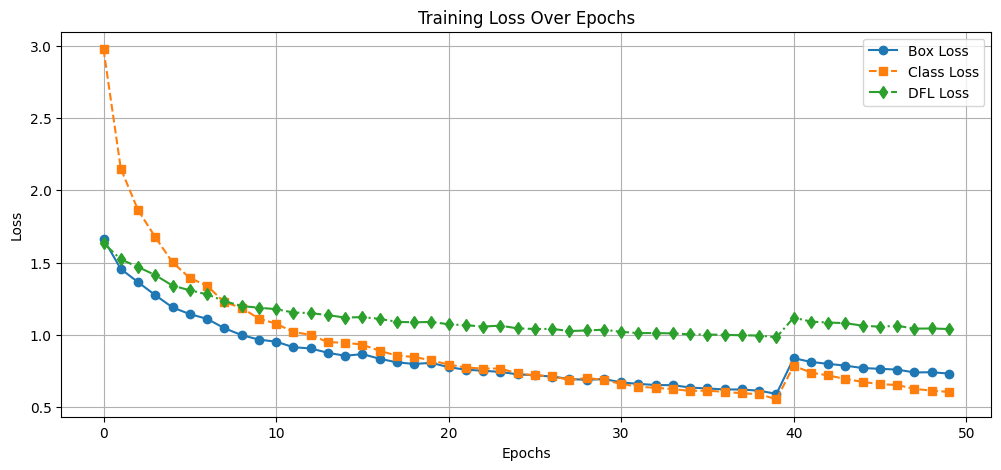

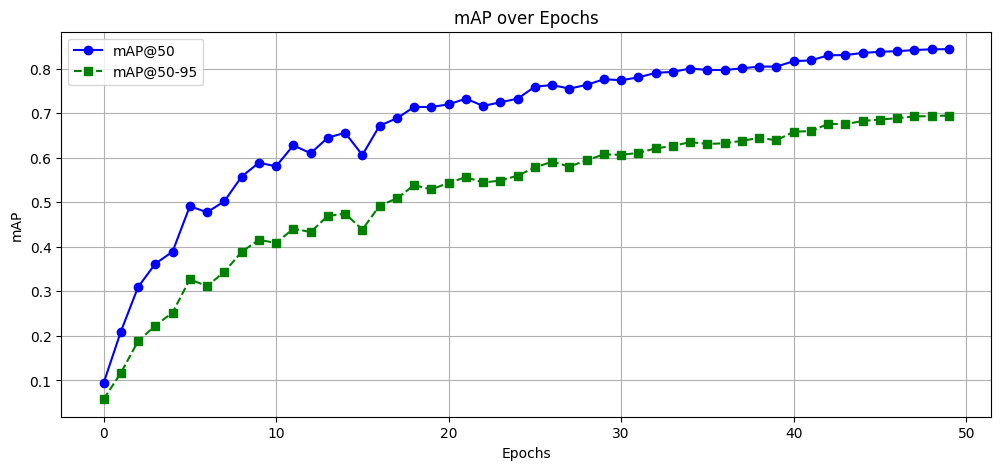

In [41]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Define test results path
test_results_path = "/kaggle/working/Yolov11_results/test_predictions/"

# Get valid image files (check if the folder exists first)
if os.path.exists(test_results_path):
    valid_extensions = (".jpg", ".png")
    sample_files = [f for f in os.listdir(test_results_path) if f.lower().endswith(valid_extensions)][:3]
else:
    sample_files = []

# Plot predictions
if sample_files:
    plt.figure(figsize=(12, 6))
    for idx, img_file in enumerate(sample_files):
        img_path = os.path.join(test_results_path, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Skipping invalid image file: {img_file}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, idx + 1)
        plt.imshow(img)
        plt.title(f"Prediction: {img_file}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid image predictions found!")

# Define path to training results CSV
results_csv = "/kaggle/working/Yolov11_results/clc_xray_yolov11/results.csv"

# Load training results
df = pd.read_csv(results_csv)

# Print actual column names to check for correct mAP column
print("CSV Columns:", df.columns)

# Extract epochs
epochs = df.index

# Extract loss and mAP values (corrected column names)
box_loss = df.get("train/box_loss", pd.Series([None] * len(df)))
cls_loss = df.get("train/cls_loss", pd.Series([None] * len(df)))
dfl_loss = df.get("train/dfl_loss", pd.Series([None] * len(df)))
map50 = df.get("metrics/mAP50(B)", df.get("metrics/mAP_50", pd.Series([None] * len(df))))
map50_95 = df.get("metrics/mAP50-95(B)", df.get("metrics/mAP_50-95", pd.Series([None] * len(df))))

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.plot(epochs, box_loss, label="Box Loss", linestyle='-', marker='o')
plt.plot(epochs, cls_loss, label="Class Loss", linestyle='--', marker='s')
plt.plot(epochs, dfl_loss, label="DFL Loss", linestyle='-.', marker='d')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP curves
plt.figure(figsize=(12, 5))
plt.plot(epochs, map50, label="mAP@50", linestyle='-', marker='o', color="blue")
plt.plot(epochs, map50_95, label="mAP@50-95", linestyle='--', marker='s', color="green")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("mAP over Epochs")
plt.legend()
plt.grid(True)
plt.show()
